In [1]:
%load_ext autoreload
%autoreload 2

### Comparing the FineTuned Fan Landmark Localization with mobileNet Results

1. read the 2d and 3d results 
2. plot 2d landmark results 
3. plot mouth opening distance 3d signal 

In [2]:
import torch
import torch.nn as nn
import torchvision 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import time
import pandas as pd
import pdb
import os
import shutil
import pyrealsense2 as rs
import cv2


In [3]:
# reading the video 
video_path = r"/media/deniz/easystore/facial_tracking_data_2021/ALS/AF18_SBK_20190826/02/RSSDK/AF18_02_20190826_NSM_OPEN_color.avi"
vid = torchvision.io.read_video(video_path, pts_unit='sec')

In [4]:
# reading the landmark values into dfs
finetuned_fan_pixel_path = r'/media/deniz/easystore/facial_tracking_data_2021/ALS/AF18_SBK_20190826/02/LANDMARKS/Diego_FaceData/landmarks_finetuned_w15/AF18_02_20190826_NSM_OPEN_landmarksFiltered.csv'
df_fan = pd.read_csv(finetuned_fan_pixel_path, index_col=0)

finetuned_fan_path = r'/media/deniz/easystore/facial_tracking_data_2021/ALS/AF18_SBK_20190826/02/LANDMARKS/Diego_FaceData/landmarks_finetuned_w15/AF18_02_20190826_NSM_OPEN_landmarksFiltered3D.csv'
df_fan3D = pd.read_csv(finetuned_fan_path, index_col=0)


mobileNet_pixel_path = r'/media/deniz/easystore/facial_tracking_data_2021/ALS/AF18_SBK_20190826/02/LANDMARKS/mobileNet/AF18_02_20190826_NSM_OPEN_color_landmarksPixels2D.csv'
df_mnet = pd.read_csv(mobileNet_pixel_path, index_col=0)


mobileNet_path = r'/media/deniz/easystore/facial_tracking_data_2021/ALS/AF18_SBK_20190826/02/LANDMARKS/mobileNet/AF18_02_20190826_NSM_OPEN_color_landmarks3D.csv'
df_mnet3D = pd.read_csv(mobileNet_path, index_col=0)


### FineTuned Dataframe

In [5]:
# 2D Data
df_fan.head()

,Video_Frame_number,Time_Stamp (s),bbox_top_x,bbox_top_y,bbox_bottom_x,bbox_bottom_y,landmark_0_x,landmark_0_y,landmark_1_x,landmark_1_y,...,landmark_63_x,landmark_63_y,landmark_64_x,landmark_64_y,landmark_65_x,landmark_65_y,landmark_66_x,landmark_66_y,landmark_67_x,landmark_67_y
0,0,0.000000,248.503937,121.724037,424.76712,356.467682,233.0,214.0,237.0,235.0,...,357.0,281.0,367.0,281.0,357.0,280.0,348.0,281.0,339.0,281.0
1,1,0.033399,248.503937,121.724037,424.76712,356.467682,236.0,215.0,242.0,235.0,...,357.0,282.0,367.0,281.0,357.0,280.0,348.0,282.0,339.0,282.0
2,2,0.066799,248.503937,121.724037,424.76712,356.467682,237.0,215.0,242.0,236.0,...,357.0,285.0,367.0,285.0,358.0,282.0,348.0,283.0,339.0,285.0
3,3,0.100198,248.503937,121.724037,424.76712,356.467682,249.0,222.0,253.0,246.0,...,359.0,286.0,367.0,289.0,359.0,289.0,349.0,291.0,339.0,292.0
4,4,0.133597,248.503937,121.724037,424.76712,356.467682,249.0,222.0,253.0,246.0,...,359.0,286.0,368.0,289.0,359.0,289.0,349.0,291.0,340.0,292.0


In [6]:
x_fan = df_fan
y_fan = df_fan
for col in df_fan.columns:
    if 'y'in col or 'landmark' not in col:
        x_fan = x_fan.drop([col], axis = 1)
    if 'x' in col or 'landmark' not in col:
        y_fan = y_fan.drop([col], axis = 1)
   # elif 'landmark' not in col:
   #     x_fan = x_fan.drop([col], axis = 1)
   #     y_fan = y_fan.drop([col], axis = 1)

In [7]:
x_fan.head()

,landmark_0_x,landmark_1_x,landmark_2_x,landmark_3_x,landmark_4_x,landmark_5_x,landmark_6_x,landmark_7_x,landmark_8_x,landmark_9_x,...,landmark_58_x,landmark_59_x,landmark_60_x,landmark_61_x,landmark_62_x,landmark_63_x,landmark_64_x,landmark_65_x,landmark_66_x,landmark_67_x
0,233.0,237.0,246.0,255.0,266.0,281.0,301.0,325.0,352.0,375.0,...,339.0,331.0,327.0,338.0,347.0,357.0,367.0,357.0,348.0,339.0
1,236.0,242.0,249.0,259.0,269.0,283.0,302.0,325.0,352.0,378.0,...,340.0,331.0,327.0,338.0,348.0,357.0,367.0,357.0,348.0,339.0
2,237.0,242.0,250.0,260.0,270.0,285.0,303.0,326.0,353.0,378.0,...,340.0,331.0,327.0,338.0,348.0,357.0,367.0,358.0,348.0,339.0
3,249.0,253.0,257.0,264.0,274.0,289.0,308.0,331.0,357.0,379.0,...,340.0,331.0,327.0,338.0,348.0,359.0,367.0,359.0,349.0,339.0
4,249.0,253.0,257.0,265.0,274.0,289.0,308.0,331.0,357.0,379.0,...,340.0,331.0,327.0,339.0,348.0,359.0,368.0,359.0,349.0,340.0


In [8]:
y_fan.head()

,landmark_0_y,landmark_1_y,landmark_2_y,landmark_3_y,landmark_4_y,landmark_5_y,landmark_6_y,landmark_7_y,landmark_8_y,landmark_9_y,...,landmark_58_y,landmark_59_y,landmark_60_y,landmark_61_y,landmark_62_y,landmark_63_y,landmark_64_y,landmark_65_y,landmark_66_y,landmark_67_y
0,214.0,235.0,255.0,273.0,288.0,306.0,316.0,321.0,320.0,314.0,...,289.0,289.0,287.0,284.0,283.0,281.0,281.0,280.0,281.0,281.0
1,215.0,235.0,255.0,274.0,289.0,307.0,319.0,322.0,321.0,316.0,...,292.0,291.0,287.0,285.0,284.0,282.0,281.0,280.0,282.0,282.0
2,215.0,236.0,260.0,275.0,293.0,309.0,320.0,326.0,325.0,320.0,...,293.0,292.0,288.0,287.0,286.0,285.0,285.0,282.0,283.0,285.0
3,222.0,246.0,267.0,287.0,308.0,325.0,337.0,345.0,345.0,338.0,...,304.0,301.0,294.0,288.0,286.0,286.0,289.0,289.0,291.0,292.0
4,222.0,246.0,267.0,288.0,308.0,325.0,337.0,345.0,345.0,338.0,...,304.0,301.0,294.0,288.0,286.0,286.0,289.0,289.0,291.0,292.0


In [9]:
# 3D Data
df_fan3D = df_fan3D.drop(df_fan3D.index[0])
df_fan3D.head()

,Video_Frame_number,Time_Stamp (s),landmark_0,landmark_0.1,landmark_0.2,landmark_1,landmark_1.1,landmark_1.2,landmark_2,landmark_2.1,...,landmark_64.2,landmark_65,landmark_65.1,landmark_65.2,landmark_66,landmark_66.1,landmark_66.2,landmark_67,landmark_67.1,landmark_67.2
0.0,0.0,0.000000,-0.07900119184788792,-0.022928319835558264,0.636806967886514,-0.07465074095975358,-0.0013958296456191642,0.634682194882771,-0.05827559817463226,0.01695013900531364,...,0.5101954941928852,0.03819961123493017,0.03551226923941896,0.5055709882435622,0.03072975680806653,0.03615550966259582,0.5031962419452611,0.023421865981740588,0.03612856815017958,0.5028212820034241
1.0,1.0,0.033399,-0.07679010620692442,-0.022152525183323755,0.6440561934286961,-0.06217437198776595,-0.0012479453704432857,0.567439378646668,-0.055595814123016236,0.01696513581044995,...,0.5109454140765592,0.03816183658846794,0.035477152038687766,0.5050710416544462,0.030706858330564246,0.036938011664961745,0.5028212820034241,0.023421865981740588,0.036938011664961745,0.5028212820034241
2.0,2.0,0.066799,-0.07585620782834353,-0.022182617882000887,0.6449310999596491,-0.062475657490790364,-0.0003361002357724784,0.5701890848868061,-0.05620809676996262,0.022116533167833897,...,0.5104454674874432,0.0390134813167097,0.03714000924304506,0.5055709882435622,0.03076028811140291,0.03781313556409843,0.5036961885343771,0.023503373842477443,0.039503336688783856,0.5045710950653302
3.0,3.0,0.100198,-0.05638214165978376,-0.013264638784393122,0.5735637243633391,-0.051322536810267806,0.008664494592003986,0.5586903133371379,-0.05189961348332196,0.029961496600307492,...,0.5118203206075123,0.04027042452900396,0.04331365536612158,0.5111953873711172,0.031821829087460694,0.04465171250223247,0.5076957612473052,0.023602347673372197,0.04537945299006317,0.5066958680690732
4.0,4.0,0.133597,-0.055202650354632475,-0.01298714797521863,0.561565006224555,-0.0517703173327735,0.00874009085354496,0.563564792581019,-0.052027734314796945,0.030035460385373053,...,0.5123202671966283,0.040339347015972915,0.043387786316625945,0.5120702939020703,0.031923671474988265,0.04479461557030953,0.5093205876619322,0.02443609817301825,0.04541303423302572,0.5070708280109102


In [10]:
df_fan3D =df_fan3D.astype({ "landmark_51": np.double, "landmark_51.1": np.double,"landmark_51.2": np.double, 
                       "landmark_57": np.double,"landmark_57.1": np.double, "landmark_57.2": np.double })

### Mobile Net Dataframe

In [11]:
# 2D Data
df_mnet.head()

,landmark_0_x,landmark_0_y,landmark_1_x,landmark_1_y,landmark_2_x,landmark_2_y,landmark_3_x,landmark_3_y,landmark_4_x,landmark_4_y,...,landmark_63_y,landmark_64_x,landmark_64_y,landmark_65_x,landmark_65_y,landmark_66_x,landmark_66_y,landmark_67_x,landmark_67_y,fps
0,252.533020,228.426147,255.125427,249.331360,260.613464,273.179016,267.364685,293.252441,277.426178,313.968903,...,283.967743,370.816498,289.341949,364.352814,290.780151,352.017517,292.938751,338.157990,293.367065,29.0
1,252.494827,227.878662,254.939499,249.512024,260.217590,273.447693,267.161957,294.119812,277.399139,314.369202,...,283.814209,369.992096,288.890686,363.508209,290.606964,351.352844,293.196838,338.066895,293.707825,29.0
2,252.825714,231.931946,255.348953,253.767059,260.903931,277.970337,267.786896,297.595642,277.748199,317.597595,...,284.899414,371.223389,290.498962,364.760376,293.146942,353.049988,294.636719,339.486023,294.871887,29.0
3,254.988907,230.836273,258.376099,252.938446,264.360382,275.079895,271.816223,295.790802,282.341949,316.810120,...,283.825928,370.055542,288.622772,364.850952,292.399628,353.019470,294.168274,339.828979,294.952393,29.0
4,254.952118,229.641235,258.135925,252.797882,263.766357,275.155090,271.664001,296.077393,282.223389,317.380249,...,284.117157,371.014801,289.104889,365.085266,292.332245,352.757874,294.297455,338.733643,295.655762,29.0


In [12]:
x_mnet = df_mnet
y_mnet = df_mnet
for col in df_mnet.columns:
    if 'y'in col:
        x_mnet = x_mnet.drop([col], axis = 1)
    elif 'x' in col:
        y_mnet = y_mnet.drop([col], axis = 1)

In [13]:
x_mnet.head()

,landmark_0_x,landmark_1_x,landmark_2_x,landmark_3_x,landmark_4_x,landmark_5_x,landmark_6_x,landmark_7_x,landmark_8_x,landmark_9_x,...,landmark_59_x,landmark_60_x,landmark_61_x,landmark_62_x,landmark_63_x,landmark_64_x,landmark_65_x,landmark_66_x,landmark_67_x,fps
0,252.533020,255.125427,260.613464,267.364685,277.426178,290.989258,308.953003,329.588196,352.319397,374.374023,...,330.183044,326.328979,338.761505,350.974243,363.570648,370.816498,364.352814,352.017517,338.157990,29.0
1,252.494827,254.939499,260.217590,267.161957,277.399139,291.472656,309.472473,330.003784,352.846558,375.323242,...,330.190613,327.038513,338.052795,350.127472,362.799377,369.992096,363.508209,351.352844,338.066895,29.0
2,252.825714,255.348953,260.903931,267.786896,277.748199,291.078674,310.203125,331.962708,354.303528,377.057739,...,330.849823,327.471130,339.429932,351.479309,363.681427,371.223389,364.760376,353.049988,339.486023,29.0
3,254.988907,258.376099,264.360382,271.816223,282.341949,295.819763,313.668823,332.936920,354.985718,376.971558,...,330.833160,326.711487,339.531860,352.157715,363.362061,370.055542,364.850952,353.019470,339.828979,29.0
4,254.952118,258.135925,263.766357,271.664001,282.223389,296.038635,313.745026,334.007690,356.350891,377.942200,...,330.536011,325.920593,339.205811,351.965851,363.178101,371.014801,365.085266,352.757874,338.733643,29.0


In [14]:
# 3D Data
df_mnet3D.head()

,Time_Stamp (s),landmark_0,landmark_0.1,landmark_0.2,landmark_1,landmark_1.1,landmark_1.2,landmark_2,landmark_2.1,landmark_2.2,...,landmark_65,landmark_65.1,landmark_65.2,landmark_66,landmark_66.1,landmark_66.2,landmark_67,landmark_67.1,landmark_67.2,depth_scale
NaN,NaN,x,y,z,x,y,z,x,y,z,...,x,y,z,x,y,z,x,y,z,NaN
0.0,0.000000,-0.051603623971284755,-0.007121935727317386,0.5571904735697899,-0.04902407952791856,0.011569355936594514,0.5543157806823729,-0.04830575738759869,0.035960456976643435,0.6068101725395536,...,0.04469723095664575,0.04480048158850613,0.5114453606656753,0.034389311282483674,0.04637282693416097,0.5091956010146532,0.022926840926114987,0.04651747967780729,0.5069458413636312,0.000125
1.0,0.033399,-0.05198537745778456,-0.007664243725355044,0.56094007298816,-0.04965582607139687,0.01184165957294459,0.5595652198680909,-0.04876267047554594,0.03627513922998659,0.6076850790705066,...,0.04403410497133751,0.044690632306066735,0.5118203206075123,0.03363678983901755,0.04629851833986847,0.5060709348326782,0.022846865593963567,0.046784030245996464,0.5068208547163522,0.000125
2.0,0.066799,-0.05160596916916313,-0.0039978696787543455,0.5600651664572069,-0.04944111867350938,0.015723569185050544,0.561315032929997,-0.0486352742129414,0.04115983301624642,0.6145593446708517,...,0.0449667573503345,0.04668057625659476,0.5106954407820012,0.03501941009078494,0.04747155261860814,0.5060709348326782,0.023975108199337427,0.047674910021175285,0.5061959214799572,0.000125
3.0,0.100198,-0.04873589117074952,-0.00489337374321737,0.5496912747330498,-0.04590497956968739,0.01471807899944084,0.5516910610895138,-0.04069140534877608,0.03446789851692135,0.5530659142095828,...,0.04511838491327401,0.04614511365395639,0.5115703473129543,0.03503776200193505,0.047148072481592966,0.5066958680690732,0.02425457529010995,0.047740511917689014,0.5061959214799572,0.000125


In [15]:
df_mnet3D = df_mnet3D.drop(df_mnet3D.index[0])
df_mnet3D.head()

,Time_Stamp (s),landmark_0,landmark_0.1,landmark_0.2,landmark_1,landmark_1.1,landmark_1.2,landmark_2,landmark_2.1,landmark_2.2,...,landmark_65,landmark_65.1,landmark_65.2,landmark_66,landmark_66.1,landmark_66.2,landmark_67,landmark_67.1,landmark_67.2,depth_scale
0.0,0.000000,-0.051603623971284755,-0.007121935727317386,0.5571904735697899,-0.04902407952791856,0.011569355936594514,0.5543157806823729,-0.04830575738759869,0.035960456976643435,0.6068101725395536,...,0.04469723095664575,0.04480048158850613,0.5114453606656753,0.034389311282483674,0.04637282693416097,0.5091956010146532,0.022926840926114987,0.04651747967780729,0.5069458413636312,0.000125
1.0,0.033399,-0.05198537745778456,-0.007664243725355044,0.56094007298816,-0.04965582607139687,0.01184165957294459,0.5595652198680909,-0.04876267047554594,0.03627513922998659,0.6076850790705066,...,0.04403410497133751,0.044690632306066735,0.5118203206075123,0.03363678983901755,0.04629851833986847,0.5060709348326782,0.022846865593963567,0.046784030245996464,0.5068208547163522,0.000125
2.0,0.066799,-0.05160596916916313,-0.0039978696787543455,0.5600651664572069,-0.04944111867350938,0.015723569185050544,0.561315032929997,-0.0486352742129414,0.04115983301624642,0.6145593446708517,...,0.0449667573503345,0.04668057625659476,0.5106954407820012,0.03501941009078494,0.04747155261860814,0.5060709348326782,0.023975108199337427,0.047674910021175285,0.5061959214799572,0.000125
3.0,0.100198,-0.04873589117074952,-0.00489337374321737,0.5496912747330498,-0.04590497956968739,0.01471807899944084,0.5516910610895138,-0.04069140534877608,0.03446789851692135,0.5530659142095828,...,0.04511838491327401,0.04614511365395639,0.5115703473129543,0.03503776200193505,0.047148072481592966,0.5066958680690732,0.02425457529010995,0.047740511917689014,0.5061959214799572,0.000125
4.0,0.133597,-0.049101108862502636,-0.005991449226593331,0.5534408741514198,-0.04634814099097258,0.01466597691943863,0.5544407673296519,-0.04113644403115424,0.034464606605170214,0.5519410343840718,...,0.04532241944356782,0.04610088263181681,0.5116953339602333,0.03485015296893263,0.04728841088694052,0.5070708280109102,0.023362011415576457,0.04831367056471265,0.5061959214799572,0.000125


In [16]:
df_mnet3D =df_mnet3D.astype({ "landmark_51": np.double, "landmark_51.1": np.double,"landmark_51.2": np.double, 
                       "landmark_57": np.double,"landmark_57.1": np.double, "landmark_57.2": np.double })

# 2D Comparison 

In [17]:
imgs = vid[0][:,:,:,:]
imgs = imgs.permute(0,3,1,2)

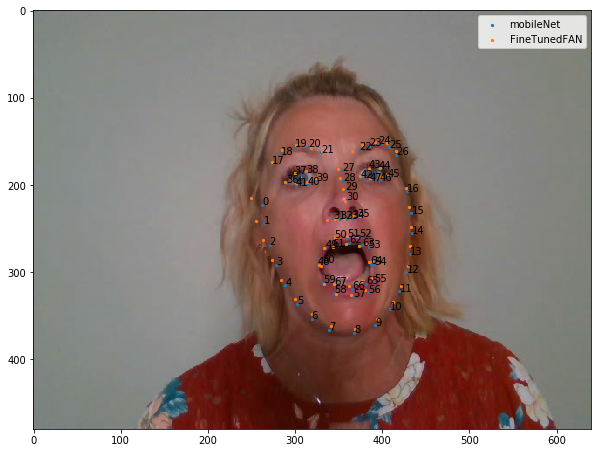

In [18]:
%matplotlib inline
n = 300

plt.figure(figsize=(10,10))

# show video
plt.imshow(imgs[n].permute(1,2,0)/255)

# show landmarks
#plt.scatter(x.iloc[300][1:],y.iloc[300][1:], label='mobileNet')
plt.scatter(x_mnet.iloc[n][:-1],y_mnet.iloc[n][:-1],s=5, label='mobileNet')
plt.scatter(x_fan.iloc[n][:],y_fan.iloc[n][:],s = 5, label='FineTunedFAN')

# mark landmark values 
for i in range(len(x_mnet.iloc[n][:-1].values)):
    
    plt.text(x_mnet.iloc[n].values[i], y_mnet.iloc[n].values[i], str(i))

plt.legend()


# 3D Comparison

In [19]:
fan_mouth_open = np.linalg.norm(df_fan3D[["landmark_51","landmark_51.1","landmark_51.2"]].to_numpy() - df_fan3D[["landmark_57","landmark_57.1","landmark_57.2"]].to_numpy(),axis=1)
print(len(fan_mouth_open))

541


In [20]:
mnet_mouth_open = np.linalg.norm(df_mnet3D[["landmark_51","landmark_51.1","landmark_51.2"]].to_numpy() - df_mnet3D[["landmark_57","landmark_57.1","landmark_57.2"]].to_numpy(),axis=1)
print(len(mnet_mouth_open))

541


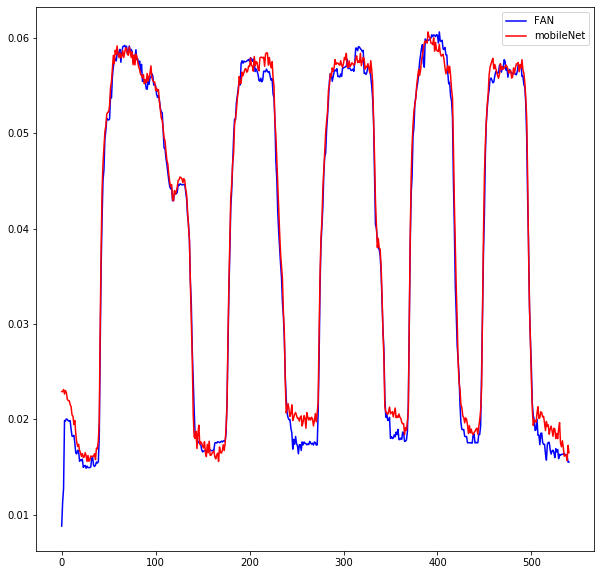

In [21]:
plt.figure(figsize=(10,10))
plt.plot(fan_mouth_open,'b', label='FAN')
plt.plot(mnet_mouth_open,'r',label='mobileNet')
plt.legend(loc="upper right")

# 3D Comparison for the rssdk format files (old recordings)

In [22]:
finetuned_fan_path = r'/media/deniz/easystore/facial_tracking_data_2021/ALS/AF01_SBK_20170509/02/LANDMARKS/Diego_FaceData/landmarks_finetuned_w15/AF01_02_20170509_NSM_OPEN_landmarksFiltered3D.csv'
df_fan3D = pd.read_csv(finetuned_fan_path, index_col=0)


mobileNet_path = r'/media/deniz/easystore/facial_tracking_data_2021/ALS/AF01_SBK_20170509/02/LANDMARKS/mobileNet/AF01_02_20170509_NSM_OPEN_color_landmarks3D.csv'
df_mnet3D = pd.read_csv(mobileNet_path, index_col=0)

In [23]:
df_fan3D = df_fan3D.drop(df_fan3D.index[0])
df_fan3D =df_fan3D.astype({ "landmark_51": np.double, "landmark_51.1": np.double,"landmark_51.2": np.double, 
                       "landmark_57": np.double,"landmark_57.1": np.double, "landmark_57.2": np.double })
df_fan3D.head()

,Video_Frame_number,Time_Stamp (s),landmark_0,landmark_0.1,landmark_0.2,landmark_1,landmark_1.1,landmark_1.2,landmark_2,landmark_2.1,...,landmark_64.2,landmark_65,landmark_65.1,landmark_65.2,landmark_66,landmark_66.1,landmark_66.2,landmark_67,landmark_67.1,landmark_67.2
0.0,0.0,0.000000,-0.0,0.0,0,-0.0,0.0,0,-0.0,0.0,...,537,16.1429472895427,43.97915805632639,531,4.808292743849131,43.18946684772982,532,-6.6183865433535125,45.356812501230046,537
1.0,1.0,0.020618,-0.0,0.0,0,-83.99311786397428,35.07688623854415,725,-0.0,0.0,...,536,16.1429472895427,43.97915805632639,531,4.799254599593776,43.97915805632639,531,-5.725253561028836,45.27234916323893,536
2.0,2.0,0.041236,-0.0,0.0,0,-84.51486528235162,35.802614919341615,740,-0.0,0.0,...,536,16.112546258865596,43.896334783150635,530,4.79021645533842,43.896334783150635,530,-5.725253561028836,45.27234916323893,536
3.0,3.0,0.061854,-0.0,0.0,0,-85.73090650943581,37.01626288270913,740,-0.0,0.0,...,537,16.173348320219805,44.061981329502146,532,4.817330888104487,43.27065005609022,533,-5.725253561028836,45.27234916323893,536
4.0,4.0,0.082472,-0.0,0.0,0,-83.99311786397428,36.26593322968124,725,-0.0,0.0,...,537,16.173348320219805,44.061981329502146,532,4.817330888104487,43.27065005609022,533,-5.735935004239711,45.356812501230046,537


In [24]:
df_mnet3D = df_mnet3D.drop(df_mnet3D.index[0])
df_mnet3D =df_mnet3D.astype({ "landmark_51": np.double, "landmark_51.1": np.double,"landmark_51.2": np.double, 
                       "landmark_57": np.double,"landmark_57.1": np.double, "landmark_57.2": np.double })
df_mnet3D.head()

,Time_Stamp (s),landmark_0,landmark_0.1,landmark_0.2,landmark_1,landmark_1.1,landmark_1.2,landmark_2,landmark_2.1,landmark_2.2,...,landmark_64.2,landmark_65,landmark_65.1,landmark_65.2,landmark_66,landmark_66.1,landmark_66.2,landmark_67,landmark_67.1,landmark_67.2
0.0,0.000000,-0.0,0.0,0,-0.0,0.0,0,-0.0,0.0,0,...,536,16.414034446768515,44.75116611491299,531,5.254374590202323,45.789250064795375,532,-5.379682554697205,47.216947908312584,536
1.0,0.020618,-0.0,0.0,0,-78.44969948475259,36.99849184348359,725,-0.0,0.0,0,...,536,17.357866371319624,45.05130858689505,532,6.927315413203156,45.272739309272744,531,-4.02594523197835,46.055221450007956,536
2.0,0.041236,-0.0,0.0,0,-82.30292310403355,41.1268434969175,740,-0.0,0.0,0,...,534,16.413848492406725,44.50319129785837,530,5.808360717690791,44.77527799066588,530,-4.0528253662605245,45.93986435203295,536
3.0,0.061854,-0.0,0.0,0,-82.65024151969155,41.543405345184,740,-0.0,0.0,0,...,536,15.936060524677625,44.67786450709595,532,5.07751594430069,45.21871271735472,532,-5.157276323646497,46.418998717110554,536
4.0,0.082472,-0.0,0.0,0,-79.5585213224812,41.12024079457245,725,-0.0,0.0,0,...,536,16.42397588389456,44.82236939273371,532,6.150273417985824,45.11177856944219,532,-4.255523443931975,46.19613629142343,537


In [25]:
fan_mouth_open = np.linalg.norm(df_fan3D[["landmark_51","landmark_51.1","landmark_51.2"]].to_numpy() - df_fan3D[["landmark_57","landmark_57.1","landmark_57.2"]].to_numpy(),axis=1)
print(len(fan_mouth_open))

506


In [26]:
mnet_mouth_open = np.linalg.norm(df_mnet3D[["landmark_51","landmark_51.1","landmark_51.2"]].to_numpy() - df_mnet3D[["landmark_57","landmark_57.1","landmark_57.2"]].to_numpy(),axis=1)
print(len(mnet_mouth_open))

506


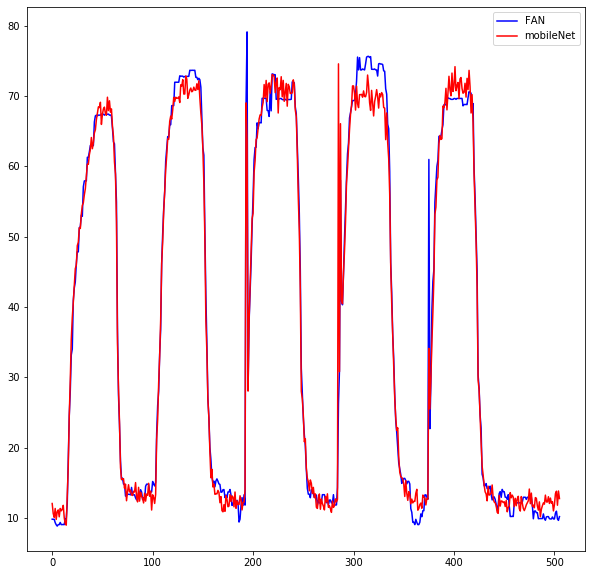

In [27]:
plt.figure(figsize=(10,10))
plt.plot(fan_mouth_open,'b', label='FAN')
plt.plot(mnet_mouth_open,'r',label='mobileNet')
plt.legend(loc="upper right")

# Unit understanding for 3D files of mobileNet 
##

1. old rrsdk file
2. one .bag file with 0.01xx factor scale
3. one .bag file with different factor scale

In [53]:
mobileNet_path = r'/media/deniz/easystore/facial_tracking_data_2021/ALS/AF11_SBK_20170928/02/LANDMARKS/mobileNet/AF11_02_20170928_NSM_OPEN_color_landmarks3D.csv'
df_mnet3D1 = pd.read_csv(mobileNet_path, index_col=0)

mobileNet_path = r'/media/deniz/easystore/facial_tracking_data_2021/ALS/AF18_SBK_20190826/02/LANDMARKS/mobileNet/AF18_02_20190826_NSM_OPEN_color_landmarks3D.csv'
df_mnet3D2 = pd.read_csv(mobileNet_path, index_col=0)


mobileNet_path = r'/media/deniz/easystore/facial_tracking_data_2021/ALS/AF05_SBK_20170530/02/LANDMARKS/mobileNet/AF05_02_20170530_NSM_OPEN_color_landmarks3D.csv'
df_mnet3D3 = pd.read_csv(mobileNet_path, index_col=0)


mobileNet_path = r'/media/deniz/easystore/facial_tracking_data_2021/ALS/AF17_SBK_20190416/02/LANDMARKS/mobileNet/AF17_02_20190416_NSM_OPEN_color_landmarks3D.csv'
df_mnet3D4 = pd.read_csv(mobileNet_path, index_col=0)

mobileNet_path = r'/media/deniz/easystore/facial_tracking_data_2021/ALS/AF14_SBK_20190129/02/LANDMARKS/mobileNet/AF14_02_20190129_NSM_OPEN_color_landmarks3D.csv'
df_mnet3D5 = pd.read_csv(mobileNet_path, index_col=0)

mobileNet_path = r'/media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP09_SBK_20191023/02/LANDMARKS/mobileNet/OP09_02_20191023_NSM_OPEN_color_landmarks3D.csv'
df_mnet3D6 = pd.read_csv(mobileNet_path, index_col=0)

mobileNet_path = r'/media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP13_SBK_20200117/02/LANDMARKS/mobileNet/OP13_02_20200117_NSM_OPEN_color_landmarks3D.csv'
df_mnet3D7 = pd.read_csv(mobileNet_path, index_col=0)

In [52]:
# 3D Data
df_mnet3D1 = df_mnet3D1.drop(df_mnet3D1.index[0])
#df_mnet3D1 = df_mnet3D1.drop(df_mnet3D1.index[0])
df_mnet3D1 =df_mnet3D1.astype({ "landmark_51": np.double, "landmark_51.1": np.double,"landmark_51.2": np.double, 
                       "landmark_57": np.double,"landmark_57.1": np.double, "landmark_57.2": np.double })

df_mnet3D1.head()

,Time_Stamp (s),landmark_0,landmark_0.1,landmark_0.2,landmark_1,landmark_1.1,landmark_1.2,landmark_2,landmark_2.1,landmark_2.2,...,landmark_64.2,landmark_65,landmark_65.1,landmark_65.2,landmark_66,landmark_66.1,landmark_66.2,landmark_67,landmark_67.1,landmark_67.2
0.0,0.000000,-0.0,0.0,0,-0.0,0.0,0,-0.0,0.0,0,...,572,37.40002688302289,70.15358628808949,565,23.620801653610656,70.58905372725486,564,10.950282165824628,71.29386977982746,570
1.0,0.020605,-0.0,0.0,0,-0.0,0.0,0,-0.0,0.0,0,...,570,36.32566582878961,70.68370440632626,564,24.438444787774102,71.47489713910682,564,11.70882972596475,72.88762208376616,571
2.0,0.041209,-69.67595836039641,27.551818208207155,778,-0.0,0.0,0,-0.0,0.0,0,...,570,37.03587227579548,70.72917105912542,565,24.590778069365985,71.30987427585052,565,11.802007304277701,72.33979849285988,570
3.0,0.061814,-0.0,0.0,0,-0.0,0.0,0,-0.0,0.0,0,...,569,37.26028127744823,70.4693463133124,565,25.29225454082016,71.37533947900215,565,12.303586297125706,72.45922271934124,571
4.0,0.082419,-0.0,0.0,0,-0.0,0.0,0,-0.0,0.0,0,...,574,36.923195466938004,71.03268495340858,566,24.599814257790673,71.46438687022537,566,12.471200383412459,72.48646377149356,572


In [30]:
df_mnet3D2 = df_mnet3D2.drop(df_mnet3D2.index[0])
#df_mnet3D2 = df_mnet3D2.drop(df_mnet3D2.index[0])
df_mnet3D2 =df_mnet3D2.astype({ "landmark_51": np.double, "landmark_51.1": np.double,"landmark_51.2": np.double, 
                       "landmark_57": np.double,"landmark_57.1": np.double, "landmark_57.2": np.double })

df_mnet3D2.head()

,Time_Stamp (s),landmark_0,landmark_0.1,landmark_0.2,landmark_1,landmark_1.1,landmark_1.2,landmark_2,landmark_2.1,landmark_2.2,...,landmark_65,landmark_65.1,landmark_65.2,landmark_66,landmark_66.1,landmark_66.2,landmark_67,landmark_67.1,landmark_67.2,depth_scale
1.0,0.033399,-0.05198537745778456,-0.007664243725355044,0.56094007298816,-0.04965582607139687,0.01184165957294459,0.5595652198680909,-0.04876267047554594,0.03627513922998659,0.6076850790705066,...,0.04403410497133751,0.044690632306066735,0.5118203206075123,0.03363678983901755,0.04629851833986847,0.5060709348326782,0.022846865593963567,0.046784030245996464,0.5068208547163522,0.000125
2.0,0.066799,-0.05160596916916313,-0.0039978696787543455,0.5600651664572069,-0.04944111867350938,0.015723569185050544,0.561315032929997,-0.0486352742129414,0.04115983301624642,0.6145593446708517,...,0.0449667573503345,0.04668057625659476,0.5106954407820012,0.03501941009078494,0.04747155261860814,0.5060709348326782,0.023975108199337427,0.047674910021175285,0.5061959214799572,0.000125
3.0,0.100198,-0.04873589117074952,-0.00489337374321737,0.5496912747330498,-0.04590497956968739,0.01471807899944084,0.5516910610895138,-0.04069140534877608,0.03446789851692135,0.5530659142095828,...,0.04511838491327401,0.04614511365395639,0.5115703473129543,0.03503776200193505,0.047148072481592966,0.5066958680690732,0.02425457529010995,0.047740511917689014,0.5061959214799572,0.000125
4.0,0.133597,-0.049101108862502636,-0.005991449226593331,0.5534408741514198,-0.04634814099097258,0.01466597691943863,0.5544407673296519,-0.04113644403115424,0.034464606605170214,0.5519410343840718,...,0.04532241944356782,0.04610088263181681,0.5116953339602333,0.03485015296893263,0.04728841088694052,0.5070708280109102,0.023362011415576457,0.04831367056471265,0.5061959214799572,0.000125
5.0,0.166996,-0.04915617582648488,-0.004041194595383322,0.5529409275623038,-0.04597448939075947,0.01597200272716081,0.5524409809731878,-0.04077463794659605,0.03632415302145502,0.5535658607986988,...,0.045531126728656966,0.04522487725881227,0.5119453072547913,0.03577318403636823,0.046427314921717935,0.5074457879527472,0.024634945437874114,0.047525969508124155,0.5063209081272362,0.000125


In [31]:
depth_scale = df_mnet3D2['depth_scale'][1]
depth_scale

0.00012498664727900175

In [32]:
df_mnet3D3 = df_mnet3D3.drop(df_mnet3D3.index[0])
#df_mnet3D3 = df_mnet3D3.drop(df_mnet3D3.index[0])
df_mnet3D3 =df_mnet3D3.astype({ "landmark_51": np.double, "landmark_51.1": np.double,"landmark_51.2": np.double, 
                       "landmark_57": np.double,"landmark_57.1": np.double, "landmark_57.2": np.double })

df_mnet3D3.head()

,Time_Stamp (s),landmark_0,landmark_0.1,landmark_0.2,landmark_1,landmark_1.1,landmark_1.2,landmark_2,landmark_2.1,landmark_2.2,...,landmark_64.2,landmark_65,landmark_65.1,landmark_65.2,landmark_66,landmark_66.1,landmark_66.2,landmark_67,landmark_67.1,landmark_67.2
1.0,0.019922,-0.0,-0.0,0,-0.0,0.0,0,-31.053024682857423,29.769283637851032,582,...,462,41.2542310254111,44.98436308110123,451,31.92811577923131,43.386460213962344,449,23.785311084387818,42.967250678051485,460
2.0,0.039844,-0.0,-0.0,0,-0.0,0.0,0,-31.372730931919588,29.20623178887405,583,...,460,42.03546230961616,47.63806708268064,454,32.787013951726884,46.5035243183045,455,23.355982883520042,45.545042271613546,461
3.0,0.059766,-0.0,-0.0,0,-34.08789785936688,4.692974597215457,592,-32.16735870334648,27.508838079456684,589,...,461,41.33461335890871,47.481243342281815,451,31.36553031564974,46.21212642286514,451,22.66008559456405,46.138259541243634,460
4.0,0.079688,-0.0,-0.0,0,-0.0,0.0,0,-32.186284173412794,30.49775094860767,583,...,471,41.418761418681036,48.47230280802416,452,31.97679630421042,47.31306547641013,456,22.773819404522765,46.22153877726326,459
5.0,0.099609,-0.0,-0.0,0,-38.96899384213515,6.667475871082917,681,-32.28006359592634,28.1344057877323,584,...,389,42.49240593679749,50.10372264794717,456,31.46011549024824,46.48977060703322,435,22.34244264655556,45.8576557027565,440


In [33]:
df_mnet3D4 = df_mnet3D4.drop(df_mnet3D4.index[0])
#df_mnet3D4 = df_mnet3D4.drop(df_mnet3D4.index[0])
df_mnet3D4 =df_mnet3D4.astype({ "landmark_51": np.double, "landmark_51.1": np.double,"landmark_51.2": np.double, 
                       "landmark_57": np.double,"landmark_57.1": np.double, "landmark_57.2": np.double })

df_mnet3D4.head()

,Time_Stamp (s),landmark_0,landmark_0.1,landmark_0.2,landmark_1,landmark_1.1,landmark_1.2,landmark_2,landmark_2.1,landmark_2.2,...,landmark_65,landmark_65.1,landmark_65.2,landmark_66,landmark_66.1,landmark_66.2,landmark_67,landmark_67.1,landmark_67.2,depth_scale
1.0,0.033396,-0.03263804963545993,-0.10521040250353023,0.6510554456763202,-0.0337496827507101,-0.08642212641580835,0.6405565673048841,-0.03397048617222659,-0.06862967239896776,0.6451810732542071,...,0.0554818854725962,-0.032278180587369636,0.5900619618041674,0.04253500516648686,-0.031557863624737656,0.5856874291494023,0.031195958589796718,-0.03250849096314355,0.5854374558548443,0.000125
2.0,0.066793,-0.03137522533926971,-0.10028730300956082,0.634557208235492,-0.033474266087299163,-0.08335315361839937,0.6408065405994421,-0.03376472094879936,-0.06493911159891057,0.6430563002504641,...,0.05235961380705215,-0.031083801008428107,0.5896870018623304,0.040477249591671566,-0.03128568100058132,0.5875622288585873,0.029784666777629754,-0.03249392385629335,0.5868123089749133,0.000125
3.0,0.100189,-0.033770548121229725,-0.10112302100217227,0.6403065940103261,-0.03631108906829062,-0.08450923720068125,0.6433062735450221,-0.03466419274258237,-0.06645018310061544,0.6439312067814171,...,0.051741123469743855,-0.03133287457106268,0.5904369217460044,0.04013735536795246,-0.03123398348679153,0.5870622822694713,0.030751250830485747,-0.031858026757342624,0.5866873223276343,0.000125
4.0,0.133585,-0.03293572295362016,-0.10152665558093084,0.6403065940103261,-0.0341901260271235,-0.08301437290850171,0.63605704800284,-0.03268265433655937,-0.06542534131341436,0.6396816607739311,...,0.0528112341522087,-0.030717795370251304,0.5910618549823994,0.04124180619880268,-0.030466612254628735,0.5875622288585873,0.03102137390989057,-0.031041673316125548,0.5874372422113083,0.000125
5.0,0.166982,-0.03362321339075909,-0.10041810153331644,0.6393067008320941,-0.03451901741806195,-0.08261585705097757,0.6401816073630471,-0.03256672774441464,-0.06596858292224585,0.6438062201341381,...,0.052522412801977794,-0.031461841738474376,0.5909368683351204,0.042074811123755516,-0.031009006250041982,0.5866873223276343,0.03206832693456093,-0.031515861813853026,0.5871872689167503,0.000125


In [34]:
# 3D Data
df_mnet3D5 = df_mnet3D5.drop(df_mnet3D5.index[0])
#df_mnet3D5 = df_mnet3D5.drop(df_mnet3D5.index[0])
df_mnet3D5 =df_mnet3D5.astype({ "landmark_51": np.double, "landmark_51.1": np.double,"landmark_51.2": np.double, 
                       "landmark_57": np.double,"landmark_57.1": np.double, "landmark_57.2": np.double })

df_mnet3D5.head()

,Time_Stamp (s),landmark_0,landmark_0.1,landmark_0.2,landmark_1,landmark_1.1,landmark_1.2,landmark_2,landmark_2.1,landmark_2.2,...,landmark_65,landmark_65.1,landmark_65.2,landmark_66,landmark_66.1,landmark_66.2,landmark_67,landmark_67.1,landmark_67.2,depth_scale
1.0,0.033396,-0.09313281463853251,-0.0084747176244585,0.5249439185718074,-0.09148402994400438,0.008716626958826017,0.5175697063823463,-0.08835774920573664,0.030614642732404475,0.5131951737275813,...,-0.013830683825363642,0.04651035080207242,0.48944771074457094,-0.022113859364236033,0.04619357493277943,0.4859480846207589,-0.03055937057872284,0.04502642226235001,0.4855731246789219,0.000125
2.0,0.066792,-0.08763164099716259,-0.011981241599889194,0.5195694927388104,-0.08564788309662402,0.0038133303415988262,0.5164448265568353,-0.08389075814175133,0.024570696251120377,0.5094455743092112,...,-0.013892823728030416,0.04254474713848661,0.48982267068640795,-0.022400906063226148,0.04117149326995997,0.4869479777989909,-0.031717669409527645,0.038089114654170544,0.4861980579153169,0.000125
3.0,0.100188,-0.09244473288840326,-0.0018362245764219044,0.5208193592116004,-0.0907646923032475,0.015383010836851225,0.5144450402003713,-0.08762702686648098,0.034643518347255535,0.5133201603748603,...,-0.012483609816028453,0.04964041816019447,0.48957269739184994,-0.02035444877812828,0.04944300946667093,0.4860730712680379,-0.030130099526388718,0.04951424340687133,0.4851981647370849,0.000125
4.0,0.133585,-0.09236155640640159,-0.0028304515834163694,0.5215692790952744,-0.09089328067239104,0.015225280109309682,0.5170697597932303,-0.08715892510163285,0.03329566852287321,0.5111953873711172,...,-0.012398708406595673,0.049155878889266494,0.48957269739184994,-0.02065147536746929,0.048924623064282406,0.4855731246789219,-0.030064015115811627,0.048993416942927484,0.48432325820613187,0.000125
5.0,0.166981,-0.0918220285779602,-0.002141555610653277,0.5205693859170424,-0.08967788752404318,0.015391015221193854,0.5111953873711172,-0.08737621347102724,0.03397424768726986,0.5123202671966283,...,-0.012336081820935757,0.048848626166293804,0.48882277750817593,-0.020358826462823113,0.048559676549901884,0.4858230979734799,-0.029562994202586505,0.048204689090998176,0.48457323150068987,0.000125


In [54]:
df_mnet3D6 = df_mnet3D6.drop(df_mnet3D6.index[0])
#df_mnet3D1 = df_mnet3D1.drop(df_mnet3D1.index[0])
df_mnet3D6 =df_mnet3D6.astype({ "landmark_51": np.double, "landmark_51.1": np.double,"landmark_51.2": np.double, 
                       "landmark_57": np.double,"landmark_57.1": np.double, "landmark_57.2": np.double })

df_mnet3D6.head()

,Time_Stamp (s),landmark_0,landmark_0.1,landmark_0.2,landmark_1,landmark_1.1,landmark_1.2,landmark_2,landmark_2.1,landmark_2.2,...,landmark_65,landmark_65.1,landmark_65.2,landmark_66,landmark_66.1,landmark_66.2,landmark_67,landmark_67.1,landmark_67.2,depth_scale
0.0,0.000000,-0.06827849959079865,-0.020037618461907804,0.5828127362619853,-0.06755754022192768,-0.002042295174546155,0.5784382036072202,-0.06571582338189012,0.01954837232751357,0.5778132703708252,...,0.033681700128479465,0.037908083516264575,0.5520660210313508,0.024448964469732104,0.03778350083038255,0.5435669290163787,0.013595157655374735,0.03811611896299962,0.5400673028925667,0.000125
1.0,0.033398,-0.06690617031327563,-0.019221513391034235,0.5816878564364742,-0.06648286223745925,-0.0015515399705705766,0.5775632970762672,-0.06390997135929312,0.01972906941085346,0.5684392718249001,...,0.03397365331732777,0.03811284840706392,0.5516910610895138,0.02426921543369079,0.038275208333025494,0.5426920224854257,0.013470517017776998,0.03852323298004182,0.5396923429507297,0.000125
2.0,0.066795,-0.06660577292489475,-0.017689985452795157,0.5808129499055212,-0.06575289251884289,0.0010830189151139424,0.5774383104289882,-0.06412432639233225,0.024004733850736197,0.5759384706616402,...,0.03487519594997897,0.03880092174190604,0.5518160477367928,0.025831720470324428,0.038557269688880846,0.5440668756054947,0.014443267105484313,0.038847399223283605,0.5405672494816827,0.000125
3.0,0.100193,-0.07119359649369876,-0.01780666461727344,0.5843125760293333,-0.06950444096564207,0.002571901214984381,0.5781882303126622,-0.06813847686995965,0.022370971952338066,0.5843125760293333,...,0.033875386881001696,0.03935701931520401,0.5505661812640028,0.024951242471847143,0.039159736690376194,0.5434419423690997,0.014557979400197471,0.03946983734150497,0.5400673028925667,0.000125
4.0,0.133591,-0.07010724924968263,-0.01628335160666449,0.5823127896728693,-0.06856145187054831,0.0038927177822938985,0.5775632970762672,-0.06711545317387368,0.024042033375716518,0.5818128430837533,...,0.03287868370191131,0.03971190598178176,0.5495662880857708,0.02446582690164594,0.03919551563893272,0.5429419957799837,0.014251719889037371,0.039526907786257524,0.5400673028925667,0.000125


In [55]:
df_mnet3D7 = df_mnet3D7.drop(df_mnet3D7.index[0])
#df_mnet3D1 = df_mnet3D1.drop(df_mnet3D1.index[0])
df_mnet3D7 =df_mnet3D7.astype({ "landmark_51": np.double, "landmark_51.1": np.double,"landmark_51.2": np.double, 
                       "landmark_57": np.double,"landmark_57.1": np.double, "landmark_57.2": np.double })

df_mnet3D7.head()

,Time_Stamp (s),landmark_0,landmark_0.1,landmark_0.2,landmark_1,landmark_1.1,landmark_1.2,landmark_2,landmark_2.1,landmark_2.2,...,landmark_65,landmark_65.1,landmark_65.2,landmark_66,landmark_66.1,landmark_66.2,landmark_67,landmark_67.1,landmark_67.2,depth_scale
0.0,0.000000,-0.06097044312201359,-0.06411158638943493,0.5330000253161415,-0.06237010961355826,-0.046498596099985454,0.5350000254111364,-0.05883943416929567,-0.026162849324629346,0.51400002441369,...,0.02741887458489284,-0.013630708937396511,0.4850000230362639,0.01879958437751629,-0.012879966062737034,0.48400002298876643,0.009584971114294818,-0.013048124146983125,0.48400002298876643,0.001
1.0,0.033321,-0.06064565820793072,-0.06507063758768494,0.5330000253161415,-0.0615351664089493,-0.04647157925181443,0.5330000253161415,-0.05796598101856687,-0.02577335800219773,0.5120000243186951,...,0.027394186193275553,-0.0135294871818521,0.4850000230362639,0.017494761813746457,-0.012732758386777746,0.48400002298876643,0.006371562894902524,-0.012746098140125653,0.48400002298876643,0.001
2.0,0.066642,-0.06211173850011649,-0.057760671126637846,0.534000025363639,-0.062081922063535064,-0.03927216492757172,0.5300000251736492,-0.05930387009846659,-0.022291868829527352,0.5300000251736492,...,0.026475077872347617,-0.013384621234372543,0.48400002298876643,0.017691355465735206,-0.012947907139236688,0.48400002298876643,0.007884936247557048,-0.012626366014009502,0.48400002298876643,0.001
3.0,0.099964,-0.06314744379840817,-0.057117180139027696,0.5360000254586339,-0.06254484402504293,-0.03913184059264904,0.5320000252686441,-0.05905666422259591,-0.02225584767775045,0.5260000249836594,...,0.027908636499445274,-0.013174829724705005,0.48600002308376133,0.017795739342266328,-0.012921191448761492,0.48400002298876643,0.0072370329991389495,-0.012858726184214745,0.48400002298876643,0.001
4.0,0.133285,-0.06260100885831718,-0.0567154171575801,0.5350000254111364,-0.06294332065268204,-0.03938659924499695,0.5350000254111364,-0.05963163612824151,-0.021894015664934315,0.5320000252686441,...,0.026918239258553522,-0.013229091289145609,0.48400002298876643,0.017692223322445397,-0.013163562464607552,0.48400002298876643,0.007931655867122247,-0.013089771677100914,0.48400002298876643,0.001


In [35]:
df_mnet3D4['depth_scale'][1]

0.00012498664727900175

In [36]:
mnet_mouth_open_1 = np.linalg.norm(df_mnet3D1[["landmark_51","landmark_51.1","landmark_51.2"]].to_numpy() - df_mnet3D1[["landmark_57","landmark_57.1","landmark_57.2"]].to_numpy(),axis=1)
print(len(mnet_mouth_open_1))

387


In [37]:
mnet_mouth_open_2 = np.linalg.norm(df_mnet3D2[["landmark_51","landmark_51.1","landmark_51.2"]].to_numpy()/(depth_scale*10) - df_mnet3D2[["landmark_57","landmark_57.1","landmark_57.2"]].to_numpy()/(depth_scale*10),axis=1)
print(len(mnet_mouth_open_2))

540


In [38]:
mnet_mouth_open_3 = np.linalg.norm(df_mnet3D3[["landmark_51","landmark_51.1","landmark_51.2"]].to_numpy() - df_mnet3D3[["landmark_57","landmark_57.1","landmark_57.2"]].to_numpy(),axis=1)
print(len(mnet_mouth_open_3))

917


In [39]:
mnet_mouth_open_4 = np.linalg.norm(df_mnet3D4[["landmark_51","landmark_51.1","landmark_51.2"]].to_numpy() - df_mnet3D4[["landmark_57","landmark_57.1","landmark_57.2"]].to_numpy(),axis=1)/(depth_scale*10)
print(len(mnet_mouth_open_4))

473


In [48]:
mnet_mouth_open_5 = np.linalg.norm(df_mnet3D5[["landmark_51","landmark_51.1","landmark_51.2"]].to_numpy() - df_mnet3D5[["landmark_57","landmark_57.1","landmark_57.2"]].to_numpy(),axis=1)/(depth_scale*10)
print(len(mnet_mouth_open_5))

mnet_mouth_open_6 = np.linalg.norm(df_mnet3D5[["landmark_51","landmark_51.1","landmark_51.2"]].to_numpy() - df_mnet3D5[["landmark_57","landmark_57.1","landmark_57.2"]].to_numpy(),axis=1)
print(len(mnet_mouth_open_6))

585
585


In [75]:
mnet_mouth_open_7 = np.linalg.norm(df_mnet3D6[["landmark_51","landmark_51.1","landmark_51.2"]].to_numpy() - df_mnet3D6[["landmark_57","landmark_57.1","landmark_57.2"]].to_numpy(),axis=1)/(depth_scale*10)
print(len(mnet_mouth_open_7))

mnet_mouth_open_77 = np.linalg.norm(df_mnet3D6[["landmark_51","landmark_51.1","landmark_51.2"]].to_numpy() - df_mnet3D6[["landmark_57","landmark_57.1","landmark_57.2"]].to_numpy(),axis=1)
print(len(mnet_mouth_open_77))

mnet_mouth_open_8 = np.linalg.norm(df_mnet3D7[["landmark_51","landmark_51.1","landmark_51.2"]].to_numpy() - df_mnet3D7[["landmark_57","landmark_57.1","landmark_57.2"]].to_numpy(),axis=1)/(depth_scale*10)
print(len(mnet_mouth_open_8))

mnet_mouth_open_88 = np.linalg.norm(df_mnet3D7[["landmark_51","landmark_51.1","landmark_51.2"]].to_numpy() - df_mnet3D7[["landmark_57","landmark_57.1","landmark_57.2"]].to_numpy(),axis=1)
print(len(mnet_mouth_open_88))

458
458
413
413


In [80]:
print(df_mnet3D6['depth_scale'][1])
print(df_mnet3D7['depth_scale'][1])

0.00012498664727900175
0.001000000047497451


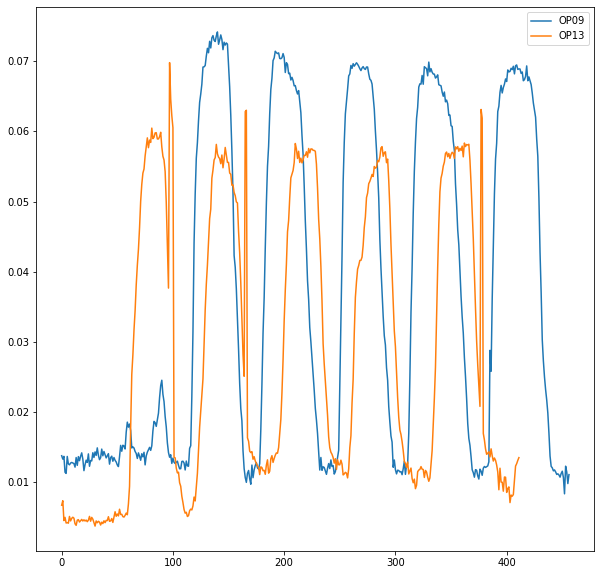

In [77]:
plt.figure(figsize=(10,10))
plt.plot(mnet_mouth_open_77,label='OP09')
plt.plot(mnet_mouth_open_88,label='OP13')
plt.legend(loc="upper right")

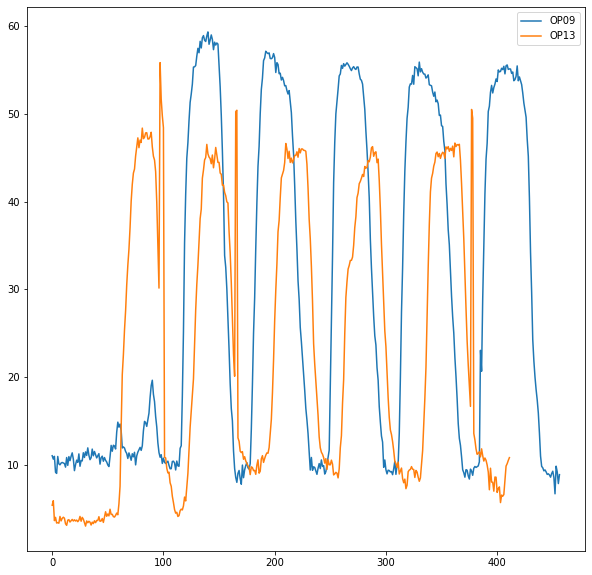

In [78]:
plt.figure(figsize=(10,10))
plt.plot(mnet_mouth_open_7,label='OP09')
plt.plot(mnet_mouth_open_8,label='OP13')
plt.legend(loc="upper right")

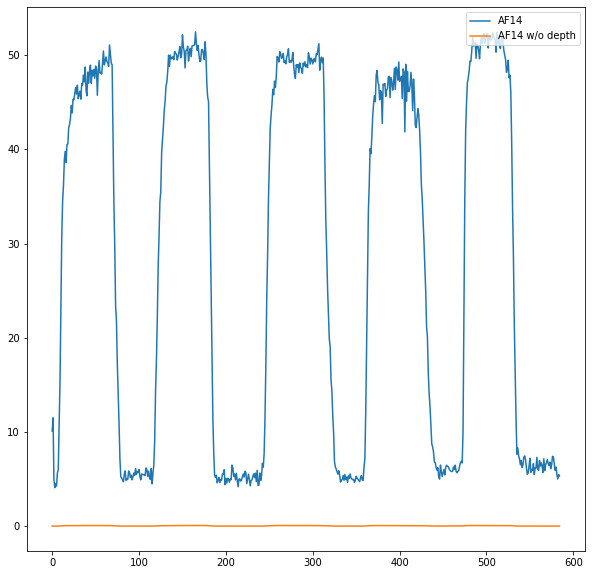

In [49]:
plt.figure(figsize=(10,10))
plt.plot(mnet_mouth_open_5,label='AF14')
plt.plot(mnet_mouth_open_6,label='AF14 w/o depth')
plt.legend(loc="upper right")

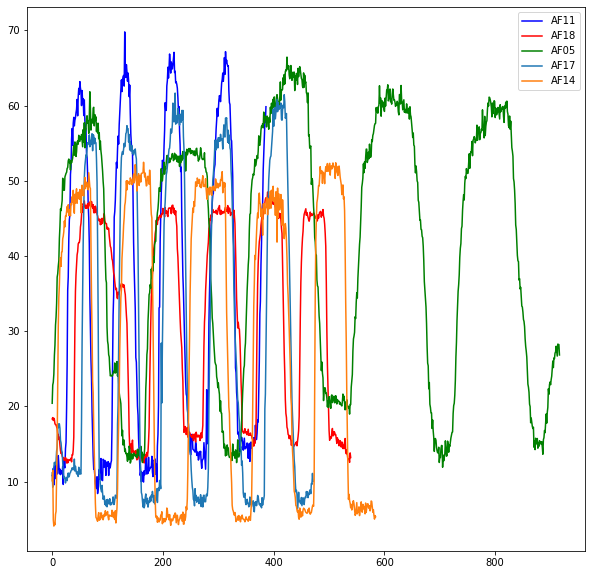

In [44]:
plt.figure(figsize=(10,10))
plt.plot(mnet_mouth_open_1,'b', label='AF11')
plt.plot(mnet_mouth_open_2,'r',label='AF18')
plt.plot(mnet_mouth_open_3,'g',label='AF05')
plt.plot(mnet_mouth_open_4,label='AF17')
plt.plot(mnet_mouth_open_5,label='AF14')
plt.legend(loc="upper right")

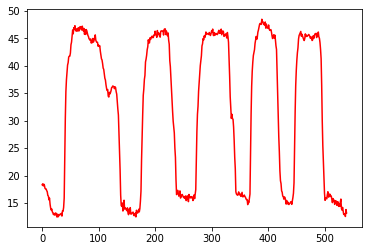

In [41]:
plt.plot(mnet_mouth_open_2,'r',label='2')

In [81]:
path =r'/media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF26_TRI_20190829/02/LANDMARKS/mobileNet/NF26_02_20190829_NSM_OPEN_color_landmarks3D.csv'
df_NF26 = pd.read_csv(path, index_col=0)

df_NF26 = df_NF26.drop(df_NF26.index[0])

df_NF26 =df_NF26.astype({ "landmark_51": np.double, "landmark_51.1": np.double,"landmark_51.2": np.double, 
                       "landmark_57": np.double,"landmark_57.1": np.double, "landmark_57.2": np.double })

NF26_open = np.linalg.norm(df_NF26[["landmark_51","landmark_51.1","landmark_51.2"]].to_numpy() - df_NF26[["landmark_57","landmark_57.1","landmark_57.2"]].to_numpy(),axis=1)
NF26_open.head()

,Time_Stamp (s),landmark_0,landmark_0.1,landmark_0.2,landmark_1,landmark_1.1,landmark_1.2,landmark_2,landmark_2.1,landmark_2.2,...,landmark_65,landmark_65.1,landmark_65.2,landmark_66,landmark_66.1,landmark_66.2,landmark_67,landmark_67.1,landmark_67.2,depth_scale
NaN,NaN,x,y,z,x,y,z,x,y,z,...,x,y,z,x,y,z,x,y,z,NaN
0.0,0.000000,-0.09425963535049048,-0.00955008417004886,0.5259438117500395,-0.09285867881452971,0.007348347272943677,0.5178196796769043,-0.09017596445984592,0.028146486840546648,0.5134451470221393,...,-0.014756167809224523,0.044948689614896044,0.48969768403912894,-0.023322092990120624,0.043943259118728956,0.4860730712680379,-0.03195800677871005,0.04170478310565997,0.4853231513843639,0.000125
1.0,0.033396,-0.09313281463853251,-0.0084747176244585,0.5249439185718074,-0.09148402994400438,0.008716626958826017,0.5175697063823463,-0.08835774920573664,0.030614642732404475,0.5131951737275813,...,-0.013830683825363642,0.04651035080207242,0.48944771074457094,-0.022113859364236033,0.04619357493277943,0.4859480846207589,-0.03055937057872284,0.04502642226235001,0.4855731246789219,0.000125
2.0,0.066792,-0.08763164099716259,-0.011981241599889194,0.5195694927388104,-0.08564788309662402,0.0038133303415988262,0.5164448265568353,-0.08389075814175133,0.024570696251120377,0.5094455743092112,...,-0.013892823728030416,0.04254474713848661,0.48982267068640795,-0.022400906063226148,0.04117149326995997,0.4869479777989909,-0.031717669409527645,0.038089114654170544,0.4861980579153169,0.000125
3.0,0.100188,-0.09244473288840326,-0.0018362245764219044,0.5208193592116004,-0.0907646923032475,0.015383010836851225,0.5144450402003713,-0.08762702686648098,0.034643518347255535,0.5133201603748603,...,-0.012483609816028453,0.04964041816019447,0.48957269739184994,-0.02035444877812828,0.04944300946667093,0.4860730712680379,-0.030130099526388718,0.04951424340687133,0.4851981647370849,0.000125


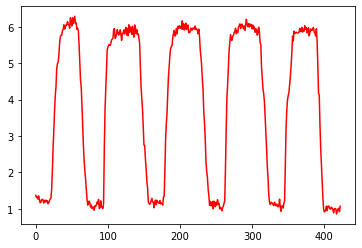

In [82]:
plt.plot(NF26_open,'r',label='2')

In [84]:
path =r'/media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF27_TRI_20190912/02/LANDMARKS/mobileNet/NF27_02_20190912_NSM_OPEN_color_landmarks3D.csv'
df_NF27 = pd.read_csv(path, index_col=0)

df_NF27 = df_NF27.drop(df_NF27.index[0])

df_NF27 =df_NF27.astype({ "landmark_51": np.double, "landmark_51.1": np.double,"landmark_51.2": np.double, 
                       "landmark_57": np.double,"landmark_57.1": np.double, "landmark_57.2": np.double })

NF27_open = np.linalg.norm(df_NF27[["landmark_51","landmark_51.1","landmark_51.2"]].to_numpy() - df_NF27[["landmark_57","landmark_57.1","landmark_57.2"]].to_numpy(),axis=1)
df_NF27.head()

,Unnamed: 0.1,Time_Stamp (s),landmark_0,landmark_0.1,landmark_0.2,landmark_1,landmark_1.1,landmark_1.2,landmark_2,landmark_2.1,...,landmark_65,landmark_65.1,landmark_65.2,landmark_66,landmark_66.1,landmark_66.2,landmark_67,landmark_67.1,landmark_67.2,depth_scale
1,0.0,0.000000,-5.678656666244202,-1.8995987034253943,61.10000000000001,-5.705850678832714,0.041566066638368614,61.10000000000001,-5.478732493275985,2.087349467116957,...,3.796688049902801,2.916002295228402,55.20000000000001,2.904432157181258,3.2968235544155458,55.00000000000001,1.748739671950291,3.5177882253240207,54.90000000000001,0.001
2,1.0,0.033483,-5.9218788547589325,-1.8186322345484491,61.60000000000001,-5.9008475271111775,0.06724061387271843,61.40000000000001,-5.690037714958917,2.032338633812958,...,3.7359566578771464,2.5398956075570855,55.10000000000001,2.763078750363404,2.819925320519039,54.90000000000001,1.8144778707263702,2.9605930333963304,54.90000000000001,0.001
3,2.0,0.066989,-5.816505493063892,-1.7711411175808087,61.40000000000001,-5.823984427996379,0.15098392044553224,61.500000000000014,-5.535883463454011,2.161617304289445,...,3.701956250489601,2.6269915368892156,55.00000000000001,2.7191289295635435,2.9343591874211046,54.80000000000001,1.6463457860826183,3.1211626130949868,54.80000000000001,0.001
4,3.0,0.100316,-6.11671632402088,-1.0881203930766545,62.20000000000001,-5.857622325667224,0.8471261308509606,61.70000000000001,-5.4746702102007125,2.671147921773927,...,3.2603925560298648,2.793655040463192,54.80000000000001,2.428692213869768,3.005318258221503,54.80000000000001,1.4959292165129465,3.218580263567542,54.80000000000001,0.001
5,4.0,0.133665,-6.044056483433484,-1.1299240402824058,62.000000000000014,-5.88188833906498,0.9198770013525285,61.80000000000001,-5.4830267768404335,2.734591800828603,...,3.3312782455940364,2.8278121888416727,54.80000000000001,2.473848041087267,3.017753573882664,54.80000000000001,1.5568515541627375,3.2104020585848945,54.80000000000001,0.001


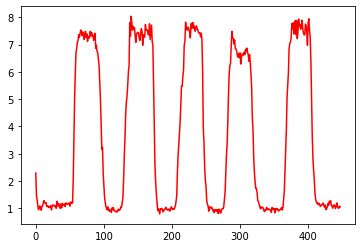

In [85]:
plt.plot(NF27_open,'r',label='2')

# Filter comparison

In [ ]:
def create_filter(time_stamps: np.ndarray, highcut, filter_order) -> np.ndarray:
        """"""
        fs = int(1 / (time_stamps[1] - time_stamps[0]))
        nyq = 0.5 * fs
        high = highcut / nyq
        b, a = signal.butter(filter_order, high, btype='low', output='ba')
        return np.array([b, a])

In [ ]:
fil_coeffs = self.create_filter(landmarks["Time_Stamp (s)"].to_numpy(), 12.5, 4)

In [ ]:
signal.filtfilt(fil_coeffs[0], fil_coeffs[1], feature)